# 一、用代码实现马尔科夫链

全文约定：转移概率矩阵P的第 ***i*** 行的每个元素，表示从第 ***i*** 个状态迁移到状态空间中其他状态的概率，即:
 <big> $$P_{ij}=P(x_i, x_j)=P\{X_{t+1} = x_j | X_t = x_i\}， 其中  (x_i, x_j ∈ S)， S为状态空间$$ </big>

## 1.1、示意代码

In [1]:
using QuantEcon

In [2]:
function mc_sample(P_init; init=1, sample_size=1000)
    X = Array(Int64, sample_size) # alloc memory
    X[1] = init # push init state
    
    # == 把初始转移概率矩阵P_init的每一行都转换为一个离散分布（Discrete distribution） == #
    # == 则P_dist的每个元素 i，分别表示状态 i 的转移概率分布
    n = size(P_init)[1]
    P_dist = [DiscreteRV(vec(P_init[i,:])) for i in 1:n]
    
    # == 根据P_dist中状态 i 的概率分布，随机选择下一个状态，填充到结果X中 == #
    for t in 1:(sample_size - 1)
        X[t+1] = draw(P_dist[X[t]])
    end
    
    return X
end

mc_sample (generic function with 1 method)

In [3]:
# 假设有 2 个状态（1，2），对应的转移概率矩阵如下P_init
P_init = [0.4 0.6;
          0.2 0.8]
mc_sample(P_init, sample_size=10)

10-element Array{Int64,1}:
 1
 1
 1
 2
 1
 1
 1
 2
 2
 1

## 1.2、 使用库函数

In [4]:
mc = MarkovChain(P_init)
simulate(mc, 10)

10-element Array{Int64,1}:
 2
 1
 2
 2
 2
 2
 2
 1
 1
 1

In [5]:
# 有具体名称的状态
mc2 = MarkovChain(P_init, ["employed", "unemployed"])
simulate(mc2, 5, init=1) # 假设初始状态是 "employed"

5-element Array{String,1}:
 "employed"  
 "employed"  
 "employed"  
 "unemployed"
 "unemployed"

# 二、平稳分布 Stationary Distributions
若转移概率矩阵为P，其平稳分布 ***V***满足：
$$V = VP $$

平稳分布的计算，可以用：
- 迭代法
- 特征向量（特征值为1的特征向量）
- 代数计算

下面通过画图直观的感受一下转移矩阵随着迭代趋近于平稳分布。

In [6]:
using Plots
pyplot()
Plots.PyPlotBackend()

Plots.PyPlotBackend()

In [7]:
# v_init 是初始概率分布
function simStationaryDist()
    # 构造一个转移概率矩阵
    P =[0.971 0.029 0.000
        0.145 0.778 0.077
        0.000 0.508 0.492]
    
    # 假设一个初始状态概率分布
    psi = [0.0 0.2 0.8]
    
    t = 20
    x_vals = Array(Float64, t+1)
    y_vals = Array(Float64, t+1)
    z_vals = Array(Float64, t+1)
    colors = []
    
    for i=1:t
        x_vals[i] = psi[1]
        y_vals[i] = psi[2]
        z_vals[i] = psi[3]
        psi = psi*P
        push!(colors, :red)
    end
    push!(colors, :black)

    # 计算平稳分布，并作为最后一个点，用黑色显示
    mc = MarkovChain(P)
    psi_star = stationary_distributions(mc)[1]
    x_vals[t+1] = psi_star[1]
    y_vals[t+1] = psi_star[2]
    z_vals[t+1] = psi_star[3]
    scatter(x_vals, y_vals, z_vals, color=colors)
    plot!(lims=(0, 1), legend=:none)
end

simStationaryDist (generic function with 1 method)


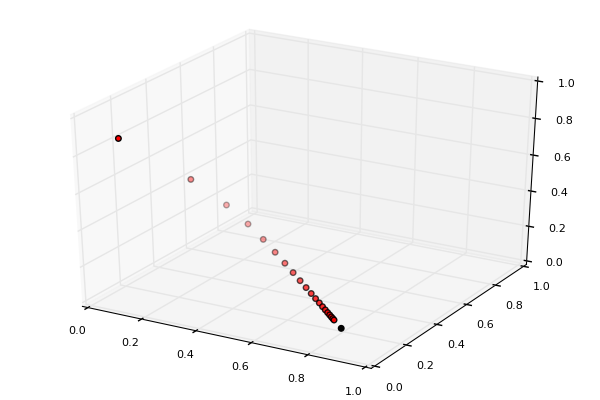

In [8]:
simStationaryDist()

# 三、极限分布

对一个不可约性的Markov过程，当 $n \to \infty$ 时，满足：
$$ \frac{1}{n}\sum_{t=1}^{n}1\{X_t = x\} \to V(x) $$

- $ 1\{X_t = x\} $ 表示当 $X_t$ == x 时取值为1，否则取值为0
- 该极限必然存在，且平稳分布就是一个合法的极限

下面用一个实际的例子，画图来直观感受一下。

假设一个Markov过程有两个状态{1, 2}, 其转移概率矩阵为：

  $$ P = \left( \begin{array}{cc}
1-a & a \\
b & 1-b \end{array} \right) $$
  
可以计算得到状态 1 的稳定分布为：
  $$ V_1 = \frac{b}{a + b} $$

不妨取 a = b = 0.1。计算随着迭代次数增加，状态 1 的极限分布和平稳分布的差值变化情况，并画图。

In [9]:
using LaTeXStrings

function simDiff()
    a = b = 0.1
    N = 10000 # 迭代次数
    v1 = b / (a + b)

    P = [1-a a
         b  1-b]
    
    mc = MarkovChain(P)
    
    labels = []
    y_vals = []
    
    for x0 = 1:2
        X = simulate_indices(mc, N; init=x0)
        
        y_bar = cumsum(X .== 1) ./ (collect(1:N))
        
        push!(labels, LaTeXString("\$X_0 = $x0\$"))
        push!(y_vals, y_bar - v1)
    end
    
    plot(y_vals, fillrange=0, fillalpha=0.1,
    ylims=(-0.25, 0.25), label=labels')
end

simDiff (generic function with 1 method)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::LaTeXStrings.LaTeXString) at ./deprecated.jl:770
 in ctranspose at ./operators.jl:315 [inlined]
 in (::Base.##209#210)(::Tuple{Int64,LaTeXStrings.LaTeXString}) at ./<missing>:0
 in copy!(::Array{Any,2}, ::Base.Generator{Base.Prod2{Base.OneTo{Int64},Array{Any,1}},Base.##209#210}) at ./abstractarray.jl:477
 in _collect(::Type{Any}, ::Base.Generator{Base.Prod2{Base.OneTo{Int64},Array{Any,1}},Base.##209#210}, ::Base.HasShape) at ./array.jl:251
 in ctranspose(::Array{Any,1}) at ./arraymath.jl:417
 in simDiff() at ./In[9]:25
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mao/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /home/mao/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[10], in expression starting on line 1



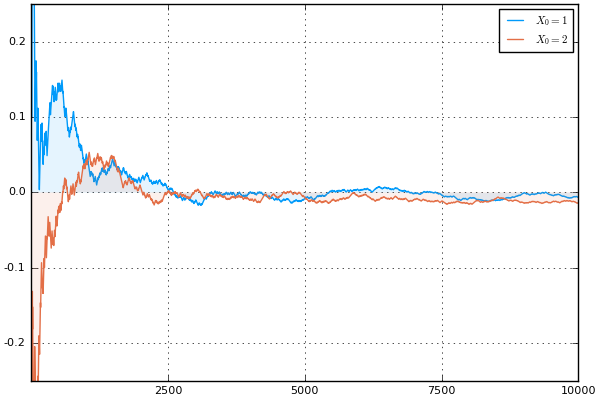

In [10]:
simDiff()

# 四、PageRank

4、用马尔科夫链实现PageRank（Exercise 2）